# Entrainement et déploiement Azure

Le but ici est de créer un environnement pour l'entraînement rapide sur le cloud de notre modèle final choisi, puis son déploiement pour l'utiliser via une API.

https://docs.microsoft.com/en-us/azure/machine-learning/how-to-set-up-training-targets

In [4]:
# !pip install PySocks

In [2]:
import sys, os
import requests
import azureml.core
from azureml.core import Workspace, Environment, Model, Dataset, Datastore
from azureml.core.authentication import ServicePrincipalAuthentication
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [4]:
subscription_id = os.environ["SUBSCRIPTION_ML"]
resource_group = os.environ["RESOURCE_GROUP_ML"]
workspace_name = os.environ["WORKSPACE_ML"]

tenant_id=os.environ["TENANT_ID"]
service_principal_id=os.environ["SERVICE_PRINCIPAL_ID"]
service_principal_password=os.environ["AZUREML_PASSWORD"]

In [5]:
svc_pr = ServicePrincipalAuthentication(
    tenant_id=tenant_id,
    service_principal_id=service_principal_id,
    service_principal_password=service_principal_password)

ws = Workspace(subscription_id=subscription_id,
               resource_group=resource_group,
               workspace_name=workspace_name,  
               auth=svc_pr
              )

In [6]:
# ws = Workspace.from_config(path="./")

# ws = Workspace(subscription_id=subscription_id,
#                resource_group=resource_group,
#                workspace_name=workspace_name)

print("Found workspace {} at location {}".format(ws.name, ws.location))

Found workspace future_vision_transport at location francecentral


In [7]:
for ds_name in ws.datastores:
    print(ds_name)

workspaceworkingdirectory
workspacefilestore
workspaceartifactstore
workspaceblobstore


### Création du dataset d'entraînement

##### Ressources:
https://docs.microsoft.com/fr-fr/learn/modules/work-with-data-in-aml/4-datasets

https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.dataset_factory.filedatasetfactory?view=azure-ml-py#azureml-data-dataset-factory-filedatasetfactory-upload-directory

https://docs.microsoft.com/fr-fr/azure/machine-learning/concept-data#access-data-in-storage

In [9]:
# !pip install azureml-dataprep

In [2]:
##### NEW METHOD #####
# create file dataset from all jpeg files in the directory
from azureml.data.datapath import DataPath

datastore = Datastore.get(ws, 'workspaceblobstore')

_ = Dataset.File.upload_directory(src_dir="./data/gtFine/",
                              target=DataPath(datastore,  'datasets/outputs'),
                              show_progress=True,overwrite=True)

In [ ]:
_ = Dataset.File.upload_directory(src_dir="./data/leftImg8bit/",
                              target=DataPath(datastore,  'datasets/inputs'),
                              show_progress=True,overwrite=True)

### Création des fichiers pour l'entraînement sur Azure

In [6]:
os.makedirs("./src/", exist_ok=True)

In [7]:
%%writefile src/train.py
import tensorflow as tf
# Si besoin de chargé un Model existant
from azureml.core import Datastore, Workspace
from azureml.core import Run

import model as mdl

from azureml.core import Model

run = Run.get_context()
ws = Workspace.from_config()

def create_checkpoint_path(root_dir,name):
    # On limite à 50 caractère max, on retire les espaces et on formate pour bien créer les dossiers
    name = name[:50]
    name = name.replace(" ","_")
    if not root_dir[-1] == "/":
        root_dir+="/"
        
    if name[0] == "/":
        name=name[1:]
        
    if not name[-1] =="/":
        name = name + "/"
        
    checkpoint_dirpath = root_dir + name
    checkpoint_filepath = checkpoint_dirpath + 'checkpoint'
    os.makedirs(checkpoint_dirpath, exist_ok=os.path.exists(checkpoint_dirpath))
    return checkpoint_filepath

def create_checkpoint_callback(root_dir :str,name: str,metric):
    checkpoint_filepath = create_checkpoint_path(root_dir,name)
    monitor_get = "val_"+ metric.name
    
    model_checkpoint_callback_gen = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor=monitor_get,
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback_gen, checkpoint_filepath

def get_all_file(root_dir,file_pattern = None):
    if root_dir[-1] != "/":
        root_dir +="/"
    train_dir = root_dir + "train/"
    val_dir = root_dir + "val/"
    
    if file_pattern is not None:
        label_id_pattern = file_pattern
    else:
        label_id_pattern = ""
    
#     print(os.listdir("./dataset"),os.listdir("./dataset/oup/"))
    train_set = []
    val_set = []
    
    # Train set
    for dir_ in os.listdir(train_dir):
        for file in os.listdir(train_dir + dir_):
            if label_id_pattern in file:
                train_set.append(train_dir + dir_ +"/"+ file)
    # Validation set
    for dir_ in os.listdir(val_dir):
        for file in os.listdir(val_dir + dir_):
            if label_id_pattern in file:
                val_set.append(val_dir + dir_ +"/"+ file)

    
    return train_set, val_set

if __name__ == "__main__":
    # Train 
    # Récupération et création des générateurs
    SIZE_IMG_X = 256
    SIZE_IMG_Y = 256
    INPUT_SHAPE = (SIZE_IMG_X,SIZE_IMG_Y,3)
    NB_CLASS = 8
    
    # Récupération du jeu de données
    datastore = Datastore.get(ws, 'workspaceblobstore')

    datastore.download("./")
    
    dir_y="./dataset/ouputs/"
    dir_x="./dataset/inputs/"
    y_train_path, y_val_path = get_all_file(dir_y,file_pattern="_labelIds.png")
    x_train_path, x_val_path = get_all_file(dir_x)
    
    
    data_train = mdl.GeneratorCitySpace(x_train_path,y_train_path,batch_size=1,crop_x=SIZE_IMG_X,crop_y=SIZE_IMG_Y)
    data_val = mdl.GeneratorCitySpace(x_val_path,y_val_path,batch_size=1,crop_x=SIZE_IMG_X,crop_y=SIZE_IMG_Y)
    
    # Création du modèle, de la métriques et du modèle checkpoint
    mean_iou_metric = mdl.Mean_IoU_custom()

    model_vgg16_unet = mdl.build_vgg16_unet(INPUT_SHAPE,n_classes=NB_CLASS)
    mdl.freeze_layer_vgg16(model_vgg16_unet)

    model_vgg16_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[mean_iou_metric])
    model_checkpoint_vgg16, file_weight_vgg16 = create_checkpoint_callback("./outputs/",
                                                                           "final_model",
                                                                           mean_iou_metric)
    _ = model_vgg16_unet.fit(data_train,  
                             verbose=1,
                             epochs=2,
#                              use_multiprocessing=True,
#                              workers=2,
                             validation_data=data_val,
                             callbacks=[model_checkpoint_vgg16])
    
    model_vgg16_unet.load_weights(file_weight_vgg16)
    model_vgg16_unet.save("./outputs/final_model")
    
#     model = run.register_model(model_name='final_model', 
#                            model_path='outputs/final_model',
#                            model_framework=Model.Framework.TENSORFLOW,
#                            model_framework_version='2.6',
#                            resource_configuration=ResourceConfiguration(cpu=2, memory_in_gb=4))
    # OR
    final_model = Model.register(model_path="./outputs/final_model",
                       model_name="final_model",
                       tags={'area': "computer_vision", 'type': "deep_learning"},
                       description="Modélisation finale réalisée sur Azure, structure UNet en transfert learning \
                       avec poids VGG16 pour la partie encodeur.",
                       workspace=ws)
    

Overwriting src/train.py


In [8]:
%%writefile src/model.py
import tensorflow as tf

from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K

from keras.models import Model

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

from tensorflow.keras.applications import VGG16

import cv2


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape,n_classes,weights="imagenet"):
    
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False, weights=weights, input_tensor=inputs)

    # Encoder 
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         

    # Bridge 
    b1 = vgg16.get_layer("block5_conv3").output          

    # Decoder 
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                      

    # Output 
    if n_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
    
def freeze_layer_vgg16(model):
    i=0
    all_layer_not_trainable = [j for j in range(1,15)] # toutes les couche VGG16
    for layer in model.layers:
        if i in all_layer_not_trainable:
            layer.trainable = False
            print('freeze layer:',layer.name)
        i+=1
        

class GeneratorCitySpace(Sequence):
        
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33,-1]
    }
    
    def _convert_mask(self,img):
        img = np.squeeze(img)
        mask = np.zeros((img.shape[0], img.shape[1], 8),dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
            elif i in self.CATS['flat']:
                mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
            elif i in self.CATS['construction']:
                mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
            elif i in self.CATS['object']:
                mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
            elif i in self.CATS['nature']:
                mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
            elif i in self.CATS['sky']:
                mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
            elif i in self.CATS['human']:
                mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
            elif i in self.CATS['vehicle']:
                mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
        return np.array(mask,dtype='uint8')
    
    def _transform_data(self,X,Y):
        if len(Y.shape) == 3:
            Y = np.expand_dims(Y, axis = 3)
        X = X /255. 
        return np.array(X,dtype=np.uint8), Y
    
    def __init__(self, image_filenames, labels, batch_size,crop_x,crop_y):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.crop_x,self.crop_y = crop_x, crop_y

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        x=[cv2.resize(cv2.imread(path_X),(self.crop_x,self.crop_y)) for path_X in batch_x]
        y = [cv2.resize(self._convert_mask(cv2.imread(path_Y,0)),(self.crop_x,self.crop_y)) for path_Y in batch_y]
        y=np.array(y)
        x=np.array(x)
        return self._transform_data(x,y)
    
class Mean_IoU_custom(tf.keras.metrics.Metric):
    def __init__(self,name='mean_iou', n_class=8, **kwargs):
        super(Mean_IoU_custom, self).__init__(name=name, dtype=None)
        self.n_class=n_class
        self.result_assign = self.add_weight('result',shape=(),initializer="zeros")

    def update_state(self, y_true, y_pred,sample_weight=None):
        if len(y_true.shape) == 4:
            y_pred = tf.argmax(y_pred,axis=3)
            y_true = tf.argmax(y_true,axis=3)
        mean_iou = 0.0
        seen_classes = 0.0
        # K.switch permet d'appliquer une condition ternaire 
        # K.equal permet de vérifier que les 2 Tensor sont égaux
        # K.cast permet de convertir un tensor en différent type (ici on utilise principalement les dtype float
        # K.sum permet d'obtenir la sum des valeurs du Tensor (matrice/vecteur)
        for c in range(self.n_class):
            labels_c = K.cast(K.equal(y_true, c), K.floatx())
            pred_c = K.cast(K.equal(y_pred, c), K.floatx())

            labels_c_sum = K.sum(labels_c)
            pred_c_sum = K.sum(pred_c)
            
            intersect = K.sum(labels_c*pred_c)
            union = labels_c_sum + pred_c_sum - intersect
            iou = intersect / union
            condition = K.equal(union, 0)
            mean_iou = K.switch(condition,mean_iou,mean_iou+iou)
            seen_classes = K.switch(condition,seen_classes,seen_classes+1)
            
        self.result_assign = K.switch(K.equal(seen_classes, 0),mean_iou,mean_iou/seen_classes)
        
    def reset_state(self):
        self.result_assign = 0
    
    def reset_states(self):
        self.result_assign = 0
    
    def result(self):
        return self.result_assign    


Overwriting src/model.py


## Création du script d'entraînement cloud

https://docs.microsoft.com/en-us/azure/machine-learning/how-to-set-up-training-targets

In [1]:
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core import ScriptRunConfig

experiment = Experiment(workspace=ws, name='experiment_train_tensorflow')

config = ScriptRunConfig(source_directory='./src',
                         script='train.py',
                         compute_target='train-model-fvt')


# Utilisation d'environement préinstaller avec tensorflow 
# env_tf = ws.environments['AzureML-tensorflow-2.4-ubuntu18.04-py37-cuda11-gpu']
# env_tf = ws.environments['AzureML-tensorflow-2.4-ubuntu18.04-py37-cpu-inference']
    
env_tf = Environment('tensorflow-custom')
env_tf.python.conda_dependencies.add_pip_package("tensorflow")
env_tf.python.conda_dependencies.add_pip_package("azureml-core")
env_tf.python.conda_dependencies.add_pip_package("opencv-python-headless")

config.run_config.environment = env_tf

run = experiment.submit(config)

aml_url = run.get_portal_url()
print(aml_url)

run.wait_for_completion(show_output=True)

## Si entraînement fait en local :

In [ ]:
path_to_model = "./data/model"

In [ ]:
final_model = Model.register(model_path=path_to_model+"/final_model",
                       model_name="final_model",
                       tags={'area': "computer_vision", 'type': "deep_learning"},
                       description="Modélisation finale réalisée en local, structure UNet en transfert learning \
                       avec poids VGG16 pour la partie encodeur.",
                       workspace=ws)

## Sinon récupération du modèle entrainé sur Azure :

In [11]:
final_model = Model(ws, 'final_model')

## Création du script d'inférence

In [12]:
source_directory = "./advanced_model"

os.makedirs(source_directory, exist_ok=True)
os.makedirs(os.path.join(source_directory, "x/y"), exist_ok=True)

In [105]:
%%writefile advanced_model/x/y/score.py
import json
import os
import re
import numpy as np
import cv2

import tensorflow as tf

from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications import VGG16


from keras.models import Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.models import Model 

from azureml.core import Datastore, Workspace
# On renome "Model" car déjà utilisé par keras
from azureml.core.model import Model as Modelazure

from PIL import Image

from azureml.core.authentication import ServicePrincipalAuthentication


def init():
    global final_model
    global x_val_path
    keras_path = Modelazure.get_model_path(model_name = 'final_model')
    INPUT_SHAPE = (256,256,3)
    NB_CLASS=8
    # Configuration authentification Workspace pour download les images du datastore
    try:
        subscription_id = os.environ["SUBSCRIPTION_ML"]
        resource_group = os.environ["RESOURCE_GROUP_ML"]
        workspace_name = os.environ["WORKSPACE_ML"]

        svc_pr_password = os.environ.get("AZUREML_PASSWORD") # Durée 6 mois
        tenant_id = os.environ.get("TENANT_ID") # ID de l'annuaire (locataire)
        service_principal_id = os.environ.get("SERVICE_PRINCIPAL_ID") # ID de l'application

        svc_pr = ServicePrincipalAuthentication(
            tenant_id=tenant_id,
            service_principal_id=service_principal_id,
            service_principal_password=svc_pr_password)

        ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group,
                   workspace_name=workspace_name,  
                   auth=svc_pr
        )
    except:
        print("Connexion not working")
        
    # Récupération du datastore
    try:
        datastore = Datastore.get(ws, 'workspaceblobstore')
        datastore.download("./img/")
    except:
        print("Download Datastore not working")
    # Récupération des images téléchargées
    try:
        dir_x="./img/dataset/inputs/"
        _, x_val_path = get_all_file(dir_x)
    except:
        print("File datastore not found")

    try: 
        print(keras_path)
        # Création du modèle final
        mean_iou_metric = Mean_IoU_custom()
        print("Metric loaded")
        final_model = build_vgg16_unet(INPUT_SHAPE,n_classes=NB_CLASS)
        print("model load correctly")
        freeze_layer_vgg16(final_model)
        print("freeze done")
        final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[mean_iou_metric])
        # Chargement de la modélisation finale
    except:
        print("Load model not working")
        
        
    try:
        final_model.load_weights(str(keras_path) + "/checkpoint")
    except:
        print("Weight model not working")
        

def get_all_file(root_dir,file_pattern = None):
    if root_dir[-1] != "/":
        root_dir +="/"
    train_dir = root_dir + "train/"
    val_dir = root_dir + "val/"
    
    if file_pattern is not None:
        label_id_pattern = file_pattern
    else:
        label_id_pattern = ""
    
#     print(os.listdir("./dataset"),os.listdir("./dataset/oup/"))
    train_set = []
    val_set = []
    
    # Train set
    for dir_ in os.listdir(train_dir):
        for file in os.listdir(train_dir + dir_):
            if label_id_pattern in file:
                train_set.append(train_dir + dir_ +"/"+ file)
    # Validation set
    for dir_ in os.listdir(val_dir):
        for file in os.listdir(val_dir + dir_):
            if label_id_pattern in file:
                val_set.append(val_dir + dir_ +"/"+ file)

    
    return train_set, val_set
        
def run(request):
    # Récupération des informations datastore
    try:
        req = json.loads(request)
        id_img = req["id"]
        img = cv2.imread(x_val_path[int(id_img)])
    except Exception as e:
        error = str(e)
        return error
    # Préprocessing / prédiction / transformation
    try:
        data_transform,size_x,size_y = preprocess_data(img)
        y_pred = final_model.predict(data_transform)
        print("prediction done")
        mask = np.argmax(y_pred,axis=3)
        mask_color = addColors(mask)
        mask_color = resize_img(mask_color,size_x,size_y)
        
        # Merge image avec mask plus orignal img
        mask_color = Image.fromarray(mask_color)
        print("Mask done")
#         mask_color.save('./prediction/predicted_mask.png')
        mask_color.putalpha(120)
        img = Image.open(x_val_path[int(id_img)])
        img.paste(mask_color, (0, 0), mask_color)
        return np.array(img).tolist()
    except Exception as e:
        error = str(e)
        return error
    
def preprocess_data(data):
    org_X = data.shape[0]
    org_Y = data.shape[1]
    img = cv2.resize(data,(256,256))
    img = img /255. 
    if len(data.shape) == 3:
        img = [img]
    img = np.array(img,dtype=np.uint64)
    return np.array(img,dtype=np.uint8),org_X,org_Y

def resize_img(img,org_X,org_Y):
    return cv2.resize(img,(org_Y,org_X),interpolation = cv2.INTER_AREA)
    
def addColors(mask):
    mask = mask[0]
    im = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)
    for i in range(mask.shape[0]):
         for u in range(mask.shape[1]):
            if mask[i,u]==7:
                    im[i,u]= np.array([0, 0, 255])
            if mask[i,u]==6:
                    im[i,u]= np.array([255, 0, 0])
            if mask[i,u]==5:
                    im[i,u]= np.array([0, 204, 204])
            if mask[i,u]==4:
                    im[i,u]= np.array([0, 255, 0])
            if mask[i,u]==3:
                    im[i,u]= np.array([255, 0, 127])
            if mask[i,u]==2:
                    im[i,u]= np.array([255, 151, 0])
            if mask[i,u]==1:
                    im[i,u]= np.array([153, 153, 0])
            if mask[i,u]==0:
                    im[i,u]= np.array([0, 0, 0])
    return im

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape,n_classes,weights="imagenet"):
    
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False, weights=weights, input_tensor=inputs)

    # Encoder 
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         

    # Bridge 
    b1 = vgg16.get_layer("block5_conv3").output          

    # Decoder 
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                      

    # Output 
    if n_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
    
def freeze_layer_vgg16(model):
    i=0
    all_layer_not_trainable = [j for j in range(1,15)] # toutes les couche VGG16
    for layer in model.layers:
        if i in all_layer_not_trainable:
            layer.trainable = False
            print('freeze layer:',layer.name)
        i+=1

class Mean_IoU_custom(tf.keras.metrics.Metric):
    def __init__(self,name='mean_iou', n_class=8, **kwargs):
        super(Mean_IoU_custom, self).__init__(name=name, dtype=None)
        self.n_class=n_class
        self.result_assign = self.add_weight('result',shape=(),initializer="zeros")

    def update_state(self, y_true, y_pred,sample_weight=None):
        if len(y_true.shape) == 4:
            y_pred = tf.argmax(y_pred,axis=3)
            y_true = tf.argmax(y_true,axis=3)
        mean_iou = 0.0
        seen_classes = 0.0
        for c in range(self.n_class):
            labels_c = K.cast(K.equal(y_true, c), K.floatx())
            pred_c = K.cast(K.equal(y_pred, c), K.floatx())

            labels_c_sum = K.sum(labels_c)
            pred_c_sum = K.sum(pred_c)
            
            intersect = K.sum(labels_c*pred_c)
            union = labels_c_sum + pred_c_sum - intersect
            iou = intersect / union
            condition = K.equal(union, 0)
            mean_iou = K.switch(condition,mean_iou,mean_iou+iou)
            seen_classes = K.switch(condition,seen_classes,seen_classes+1)
            
        self.result_assign = K.switch(K.equal(seen_classes, 0),mean_iou,mean_iou/seen_classes)
        
    def reset_state(self):
        self.result_assign = 0
    
    def reset_states(self):
        self.result_assign = 0
    
    def result(self):
        return self.result_assign    


Overwriting advanced_model/x/y/score.py


In [106]:
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice

env_tf_2 = Environment('tensorflow-custom_v1')
env_tf_2.python.conda_dependencies.add_pip_package("tensorflow")
env_tf_2.python.conda_dependencies.add_pip_package("azureml-core")
env_tf_2.python.conda_dependencies.add_pip_package("Pillow")
env_tf_2.python.conda_dependencies.add_pip_package("opencv-contrib-python-headless")

## Variable environement
env_tf_2.environment_variables['SUBSCRIPTION_ML'] = subscription_id
env_tf_2.environment_variables['RESOURCE_GROUP_ML'] = resource_group
env_tf_2.environment_variables['WORKSPACE_ML'] = workspace_name

env_tf_2.environment_variables['TENANT_ID'] = tenant_id
env_tf_2.environment_variables['SERVICE_PRINCIPAL_ID'] = service_principal_id
env_tf_2.environment_variables['AZUREML_PASSWORD'] =service_principal_password


inference_config = InferenceConfig(source_directory=source_directory,
                                   entry_script="x/y/score.py",
                                   environment=env_tf_2)

In [107]:
# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 2, memory_gb = 4,auth_enabled=True)

# Define the model, inference, & deployment configuration and web service name and location to deploy
service = Model.deploy(
    workspace = ws,
    name = "semantic-segmentation",
    models = [final_model],
    inference_config = inference_config,
    deployment_config = deployment_config)

service.wait_for_deployment(show_output = True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-02-03 14:53:57+00:00 Creating Container Registry if not exists.
2022-02-03 14:53:57+00:00 Registering the environment.
2022-02-03 14:53:59+00:00 Use the existing image.
2022-02-03 14:53:59+00:00 Generating deployment configuration.
2022-02-03 14:54:00+00:00 Submitting deployment to compute.
2022-02-03 14:54:07+00:00 Checking the status of deployment semantic-segmentation..
2022-02-03 14:56:52+00:00 Checking the status of inference endpoint semantic-segmentation.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [5]:
primary, secondary = service.get_keys()
print(primary)
print(service.scoring_uri)

## Test du modèle

In [109]:
%%time
input_payload = json.dumps({
    'id':1
})

output = service.run(input_payload)

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 15.6 s


In [111]:
output = np.array(output)
output

array([[[ 59,  60,  57],
        [ 57,  59,  55],
        [ 55,  57,  53],
        ...,
        [135, 135, 134],
        [131, 135, 124],
        [ 79,  81,  52]],

       [[ 78,  83,  65],
        [ 76,  80,  62],
        [ 73,  78,  61],
        ...,
        [135, 135, 134],
        [131, 135, 124],
        [ 82,  84,  57]],

       [[ 35,  46,  32],
        [ 35,  46,  32],
        [ 35,  46,  32],
        ...,
        [135, 135, 134],
        [131, 135, 125],
        [ 84,  86,  61]],

       ...,

       [[ 24,  35,  35],
        [ 25,  37,  36],
        [ 25,  37,  38],
        ...,
        [ 28,  38,  40],
        [ 28,  38,  40],
        [ 28,  39,  40]],

       [[ 24,  35,  35],
        [ 25,  37,  36],
        [ 25,  37,  38],
        ...,
        [ 37,  43,  39],
        [ 26,  37,  38],
        [ 27,  37,  38]],

       [[ 24,  35,  35],
        [ 25,  37,  36],
        [ 25,  37,  38],
        ...,
        [ 38,  43,  40],
        [ 38,  43,  40],
        [ 38,  43,  40]]

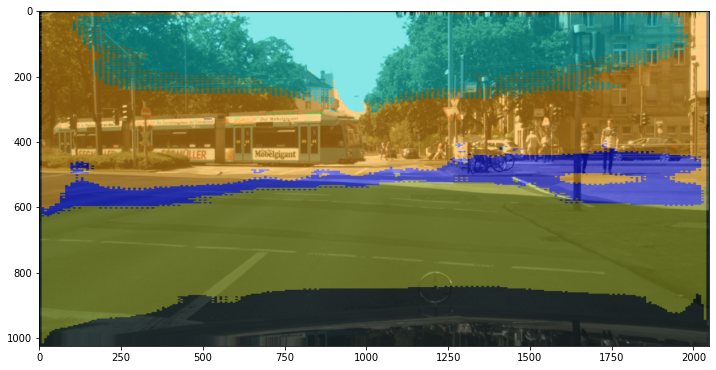

In [112]:
plt.figure(figsize=(12,10))
plt.imshow(output)

In [104]:
service.delete()